In [ ]:
!nvidia-smi

Thu Sep 26 10:11:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 510 (delta 142), reused 140 (delta 140), pack-reused 306 (from 1)
Receiving objects: 100% (510/510), 83.47 MiB | 19.12 MiB/s, done.
Resolving deltas: 100% (159/159), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.7 MB/s eta 0:00:00
 

In [ ]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 46.8 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [ ]:
# Initialize torch settings
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# Set device and paths
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HOME = os.getcwd()
CHECKPOINT = "/content/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

# Build the SAM2 video predictor model
sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [ ]:
# Set scale factor for resizing frames
SCALE_FACTOR = 0.5

# Define source video path and prepare frames directory
SOURCE_VIDEO = "/content/sheep_on_farm_wide.mp4"
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

# Extract frames from the video
cap = cv2.VideoCapture(SOURCE_VIDEO)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames: {total_frames}")
cap.release()

Total frames: 443


In [ ]:
frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=0, end=total_frames)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

# Define target video and frame paths
TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))
SOURCE_IMAGE = SOURCE_FRAMES / "00000.jpeg"

In [ ]:

inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())
sam2_model.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 443/443 [00:25<00:00, 17.45it/s]


In [ ]:
# sam2_model.reset_state(inference_state)

In [ ]:

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64," + encoded

In [ ]:

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()


from jupyter_bbox_widget import BBoxWidget


widget = BBoxWidget()
widget.image = encode_image(SOURCE_IMAGE)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
# After drawing bounding boxes, access them
boxes = widget.bboxes

# Extract points and assign unique object IDs
points = []
labels = []
object_ids = []

for idx, box in enumerate(boxes):
    # Calculate the center point of the bounding box
    x = box['x'] + box['width'] / 2
    y = box['y'] + box['height'] / 2
    points.append([x, y])
    labels.append(1)
    object_ids.append(idx + 1)  # Unique object ID starting from 1

points = np.array(points, dtype=np.float32)
labels = np.array(labels)
object_ids = np.array(object_ids)


FRAME_IDX = 0  # Starting frame index

for idx, obj_id in enumerate(object_ids):
    point = points[idx].reshape(1, 2)
    label = labels[idx].reshape(1)
    sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=obj_id,
        points=point,
        labels=label,
    )

# Define the folder path within the HOME directory where segmented frames will be saved
segmented_frames_folder = os.path.join(HOME, "segmented_frames")
os.makedirs(segmented_frames_folder, exist_ok=True)  # Create folder if it doesn't exist

# Get video information and adjust dimensions based on scale factor
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

frame_paths = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

In [ ]:
# Import ColorPalette for assigning unique colors to each object
from supervision.draw.color import ColorPalette

# Initialize a color palette
palette = ColorPalette(colors=['red', 'green', 'blue'])

# Process the video frames and apply the masks
with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, obj_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = frame_paths[frame_idx]
        frame = cv2.imread(frame_path)

        # Convert mask logits to binary masks with a threshold
        masks = (mask_logits > 0.5).squeeze().cpu().numpy().astype(np.uint8)  # Shape: (N, H, W)

        # Ensure masks are 3D
        if masks.ndim == 2:
            masks = masks[np.newaxis, ...]

        # Create an empty image for the combined mask
        combined_mask = np.zeros_like(frame)

        # Apply each mask with its unique color
        for idx, mask in enumerate(masks):
            obj_id = obj_ids[idx]
            color = palette.by_idx(obj_id)  # Get a unique color for each object

            # Convert color to RGB values using a dictionary lookup
            color_dict = {'red': (255, 0, 0), 'green': (0, 255, 0), 'blue': (0, 0, 255)}
            r, g, b = color_dict[color]

            # Apply color to the mask area
            combined_mask[mask == 1] = [r, g, b]

        # Save the segmented frame into the specified folder
        segmented_frame_path = os.path.join(segmented_frames_folder, f"frame_{frame_idx:05d}.png")
        cv2.imwrite(segmented_frame_path, combined_mask)

        # Write the frame to the video
        sink.write_frame(combined_mask)

# Display a message when processing is complete
print("Video segmentation complete. Segmented frames and video have been saved.")

propagate in video: 100%|██████████| 443/443 [15:15<00:00,  2.07s/it]

Video segmentation complete. Segmented frames and video have been saved.


In [ ]:
!zip -r /content/file.zip /content/segment-anything-2/segmented_frames

  adding: content/segment-anything-2/segmented_frames/ (stored 0%)
  adding: content/segment-anything-2/segmented_frames/frame_00363.png (deflated 73%)
  adding: content/segment-anything-2/segmented_frames/frame_00249.png (deflated 81%)
  adding: content/segment-anything-2/segmented_frames/frame_00398.png (deflated 70%)
  adding: content/segment-anything-2/segmented_frames/frame_00170.png (deflated 63%)
  adding: content/segment-anything-2/segmented_frames/frame_00264.png (deflated 83%)
  adding: content/segment-anything-2/segmented_frames/frame_00153.png (deflated 64%)
  adding: content/segment-anything-2/segmented_frames/frame_00113.png (deflated 61%)
  adding: content/segment-anything-2/segmented_frames/frame_00346.png (deflated 86%)
  adding: content/segment-anything-2/segmented_frames/frame_00240.png (deflated 78%)
  adding: content/segment-anything-2/segmented_frames/frame_00414.png (deflated 69%)
  adding: content/segment-anything-2/segmented_frames/frame_00111.png (deflated 58%

In [ ]:
# # Extract points and assign unique object IDs
# boxes = widget.bboxes

# points = []
# labels = []
# object_ids = []

# for idx, box in enumerate(boxes):
#     # Extract center point of the bounding box
#     x = box['x'] + box['width'] / 2
#     y = box['y'] + box['height'] / 2
#     points.append([x, y])
#     labels.append(1)  # Positive label for object presence
#     object_ids.append(idx + 1)  # Unique object ID starting from 1

# points = np.array(points, dtype=np.float32)
# labels = np.array(labels)
# object_ids = np.array(object_ids)

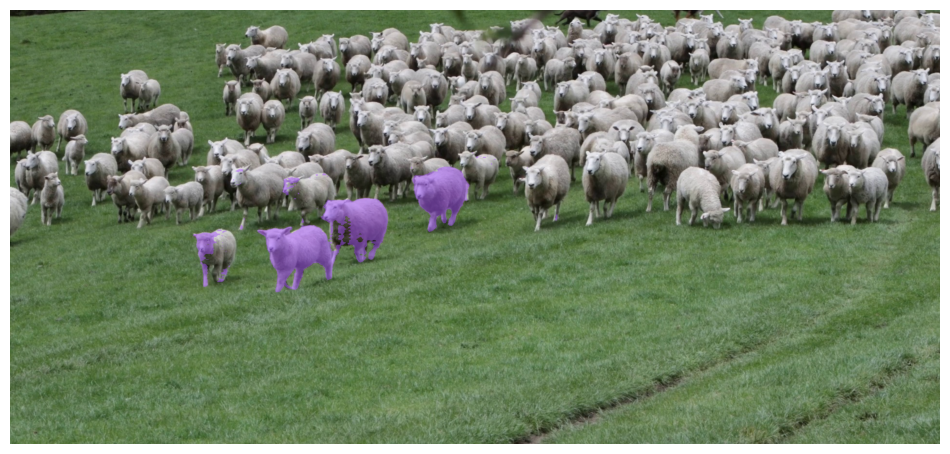

In [ ]:
# img_bgr = cv2.imread(SOURCE_IMAGE)
# mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=masks),
#     mask=masks,
#     class_id=np.array(object_ids)
# )

# segemnted_image = mask_annotator.annotate(scene=img_bgr.copy(), detections=detections)

# polygon_annotator = sv.PolygonAnnotator()
# annotated_frame = polygon_annotator.annotate(
# scene=segemnted_image.copy(),
# detections=detections
# )
# sv.plot_image(segemnted_image)





In [ ]:
# # Define the folder path within the HOME directory where segmented frames will be saved
# segmented_frames_folder = os.path.join(HOME, "segmented_frames")
# os.makedirs(segmented_frames_folder, exist_ok=True)  # Create folder if it doesn't exist

# video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
# video_info.width = int(video_info.width * SCALE_FACTOR)
# video_info.height = int(video_info.height * SCALE_FACTOR)

# frame_paths = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

# with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
#     for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
#         frame_path = frame_paths[frame_idx]
#         frame = cv2.imread(frame_path)

#         # Convert mask logits to boolean masks
#         masks = (mask_logits[0] > 0.0).cpu().numpy()

#         # Ensure masks is 3D
#         if masks.ndim == 4:  # Possibly extra dimension, squeeze to (N, W, H)
#             masks = np.squeeze(masks)
#         elif masks.ndim == 2:  # If it becomes 2D, add back the batch dimension
#             masks = masks[np.newaxis, ...]

#         # Create a binary mask with white for the object and black for the background
#         binary_mask = np.where(masks[0] > 0.0, 255, 0).astype(np.uint8)

#         # Create an empty black image with the same size as the original frame
#         black_image = np.zeros_like(frame)

#         # Apply the binary mask to the black image (white mask, black background)
#         masked_image = cv2.bitwise_and(black_image, black_image, mask=binary_mask)

#         # Set the white pixels in the mask area
#         masked_image[binary_mask == 255] = [255, 255, 255]  # White for the mask area

#         # Save the segmented frame into the specified folder as an image
#         segmented_frame_path = os.path.join(segmented_frames_folder, f"frame_{frame_idx:05d}.png")
#         cv2.imwrite(segmented_frame_path, masked_image)  # Save the black and white frame

#         # Save the processed frame with the white mask and black background to the video
#         sink.write_frame(masked_image)

propagate in video: 100%|██████████| 443/443 [08:48<00:00,  1.19s/it]


In [ ]:
#  !zip -r /content/log.zip {HOME}/segmented_frames

  adding: content/segmented_frames/ (stored 0%)
  adding: content/segmented_frames/frame_00345.png (deflated 98%)
  adding: content/segmented_frames/frame_00039.png (deflated 80%)
  adding: content/segmented_frames/frame_00178.png (deflated 72%)
  adding: content/segmented_frames/frame_00163.png (deflated 73%)
  adding: content/segmented_frames/frame_00035.png (deflated 80%)
  adding: content/segmented_frames/frame_00164.png (deflated 74%)
  adding: content/segmented_frames/frame_00033.png (deflated 80%)
  adding: content/segmented_frames/frame_00328.png (deflated 98%)
  adding: content/segmented_frames/frame_00441.png (deflated 98%)
  adding: content/segmented_frames/frame_00302.png (deflated 98%)
  adding: content/segmented_frames/frame_00095.png (deflated 78%)
  adding: content/segmented_frames/frame_00146.png (deflated 74%)
  adding: content/segmented_frames/frame_00259.png (deflated 98%)
  adding: content/segmented_frames/frame_00260.png (deflated 98%)
  adding: content/segmented_